In [2]:
#####Credit Card Fraud Detection using Extreme Gradient Boosting

# import packages
print(__doc__)
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

file = "/home/malick/Bureau/Stage_Projet_RTS/usecase/credit_card_fraud_detection/data/creditcard.csv"

dataframe = pd.read_csv(file)

Automatically created module for IPython interactive environment


In [6]:
dataframe.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
# get dataframe dimensions
print ("Dimension of dataset:", dataframe.shape)

Dimension of dataset: (284807, 31)


In [12]:
# get attribute summaries
print(dataframe.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [13]:
# get class distribution
print("Normal transaction:", dataframe['Class'][dataframe['Class'] == 0].count()) #class = 0
print("Fraudulent transaction:", dataframe['Class'][dataframe['Class'] == 1].count()) #class = 1

Normal transaction: 284315
Fraudulent transaction: 492


In [18]:
# separate classes into different datasets
class0 = dataframe.query('Class == 0')
class1 = dataframe.query('Class == 1')

# randomize the datasets
class0 = class0.sample(frac=1)
class1 = class1.sample(frac=1)

In [20]:
# undersample majority class due to class imbalance before training - train
class0train = class0.iloc[0:6000]
class1train = class1

# combine subset of different classes into one balaced dataframe
train = class0train.append(class1train, ignore_index=True).values

In [26]:
# split data into X and y
X = train[:,0:30].astype(float)
Y = train[:,30]

In [36]:
##### The Learning Algorithm: XGBoost

# XGBoost CV model
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=7)

# use area under the precision-recall curve to show classification accuracy
scoring = 'roc_auc'
results = cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.981 (0.011)


In [37]:
# change size of Matplotlib plot
fig_size = plt.rcParams["figure.figsize"] # Get current size

old_fig_params = fig_size
# new figure parameters
fig_size[0] = 12
fig_size[1] = 9
   
plt.rcParams["figure.figsize"] = fig_size # set new size

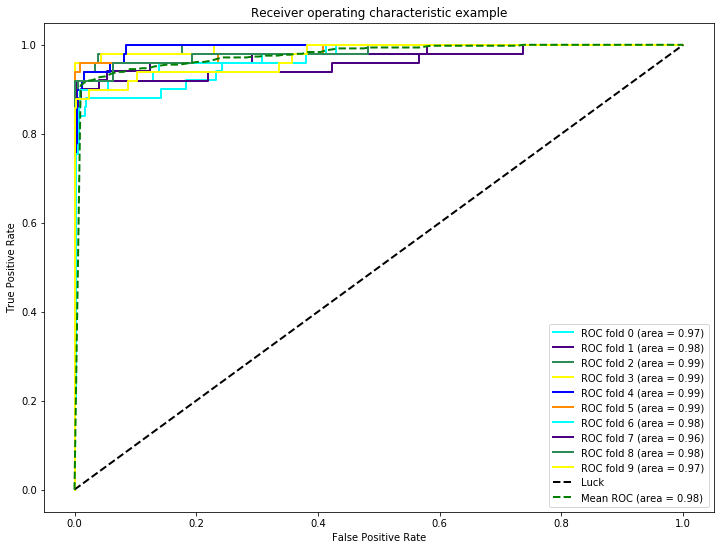

In [39]:
# plot roc-curve
# code adapted from http://scikit-learn.org
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(kfold.split(X, Y), colors):
    probas_ = model.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= kfold.get_n_splits(X, Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# ###Remarques
# D'après les résultats ci-dessus, notre algorithme a obtenu un score auc-roc 
# (c'est-à-dire la surface sous la courbe de rappel de précision) de 0,979. 
# La courbe auc-roc est insensible au déséquilibre de classe et constitue donc la mesure 
# d'évaluation recommandée pour estimer la performance de notre fonction d'apprentissage.

# ####Remarques supplémentaires
# Plusieurs autres techniques pouvant être explorées / comparées:

# Visualisation pour comprendre les tendances des transactions au fil du temps, 
# davantage d'idées peuvent être obtenues pour mieux comprendre les transactions frauduleuses
# Recherchez des techniques d'apprentissage en profondeur pour résoudre ce problème, 
# telles que les réseaux de neurones récurrents à l'aide de la composante temps pour un apprentissage séquence à séquence.
# Envisagez d'autres options d'apprentissage telles que la détection d'anomalies ou la détection de changements